In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)


... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [5]:
X.shape,X.dtype,Y.shape,Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [6]:
C = torch.randn((vocab_size, 2)) # each character gets embedded into a 2d vector

In [7]:
C[5]

tensor([1.2837, 1.1243])

In [8]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [9]:
w = torch.randn((6,100))
b1 = torch.randn(100)

In [10]:
# torch.cat(torch.unbind(emb, 1),1)

In [11]:
h = torch.tanh(emb.view(-1,6) @ w + b1)# (32,6) @ (6,100) -> (32,100)
h.shape

torch.Size([32, 100])

In [12]:
h

tensor([[-0.2811,  1.0000,  0.9998,  ...,  0.7488,  0.4205,  0.5522],
        [-0.9993,  1.0000,  0.9989,  ..., -0.0561,  0.9589, -0.8677],
        [-0.6420,  1.0000,  0.9879,  ...,  0.9858,  0.4230, -0.7143],
        ...,
        [-0.9670,  0.9986,  0.2415,  ..., -0.8332, -0.9941, -0.5085],
        [-0.0998,  0.9973,  0.8675,  ..., -0.7143, -0.8295, -0.6967],
        [ 0.0074, -0.9683, -0.0776,  ...,  0.8403, -0.9987,  0.9873]])

In [13]:
w2 = torch.randn((100, vocab_size))
b2 = torch.randn(vocab_size)

In [14]:
logits = h @ w2 + b2 # (32,100) @ (100,27) -> (32,27)
prob = F.softmax(logits, dim=1)


In [15]:
loss = -prob[torch.arange(len(logits)), Y].log().mean()
loss

tensor(18.0157)

In [16]:
F.cross_entropy(logits, Y) # Under the hood pytorch substracts max logits for numerical stability

tensor(18.0157)

improved

In [17]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [18]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [19]:
sum(p.nelement() for p in parameters) # number of parameters in total


11897

In [25]:
for p in parameters:
  p.requires_grad = True

In [26]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [27]:
lri = []
lossi = []
stepi = []

In [29]:
for i in range(1000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (1024,))
  # ix = torch.arange(Xtr.shape[0])

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  # lr = lrs[i]
  # lr = 0.1 if i < 100000 else 0.01
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

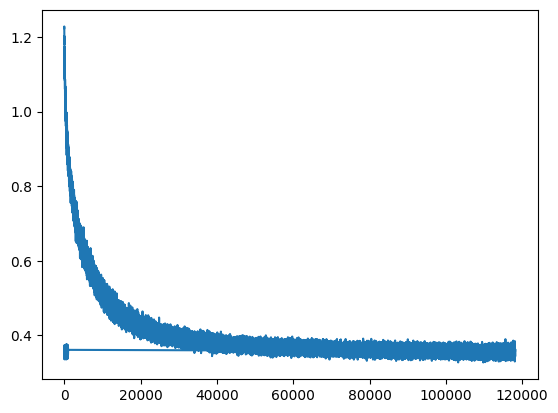

In [30]:
plt.plot(stepi, lossi)


In [31]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2708, grad_fn=<NllLossBackward0>)

In [32]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2791, grad_fn=<NllLossBackward0>)

In [33]:
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2818, grad_fn=<NllLossBackward0>)

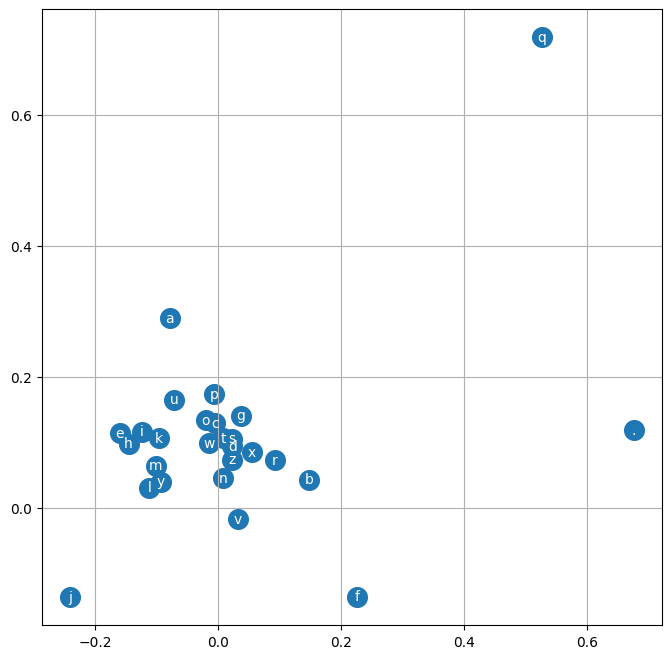

In [34]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [35]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [49]:
stoi['e']

5

In [52]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    # context = [0] * block_size # initialize with all ...
    context = [1,12,5]

    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      if ix == 0:
        break
      out.append(ix)

    print('ale'+''.join(itos[i] for i in out))

alena
aleezh
aleah
aleyll
alei
alekimrix
alee
alety
alessandane
aler
aleonen
aleegh
aley
aleci
aleanni
alen
alelania
aleciaiiv
aley
alene
